In [93]:
learning_rate = 0.1  # customize this

DATASET_REL_PATH = "./dnn2020-1/"  # there must be 'train' and 'test' directories here

batch_size = 50

num_epochs = 10

# TODO LIST

# wczytywac wszystkie zdjecia, teraz robi tylko 1xx.jpg


In [75]:
from PIL import Image
from pathlib import Path
import numpy as np


train_dir = Path(DATASET_REL_PATH) / "train"

pil2numpy = lambda img : np.asarray(img)  # returns (250, 250, 3)
pil2tensor = transforms.ToTensor()        # returns (3, 250, 250)
show_tensor = lambda img : imshow(np.transpose(img, (1,2,0)), interpolation='nearest')
tens2pil = transforms.ToPILImage()


TRAIN_DATASET = []  # :: [(anno, img :: (250, 250, 3))] 

for path in train_dir.rglob('1*.jpg'):
    anno = path.parts[-2]
    im=img2tensor(Image.open(path))
    TRAIN_DATASET.append((anno, im))

torch.Size([3, 250, 250])


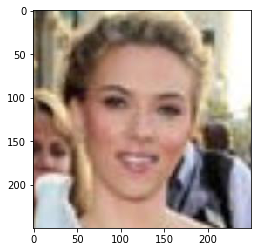

In [76]:
_first = TRAIN_DATASET[0][1]
print(_first.shape)
show_tensor(_first)

In [90]:
%matplotlib inline

from matplotlib.pyplot import imshow
import torchvision
from torchvision import datasets, transforms

trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

train_dataset = torchvision.datasets.MNIST(root='.', train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root='.', train=False, transform=trans)

In [79]:
import torch.nn as nn

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [80]:
from torch import optim

model = ConvNet()

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [91]:
from torch.utils.data import DataLoader
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
import torch

total_step = len(train_loader)
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))